# ThE raNDom WALkERS - Notebook report
__Members:__ Jonathan Doenz, Wentao Feng, Yuxuan Wang

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
import pickle
import scipy.stats as st
import numpy as np
import scipy as sp
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm, trange

from funcs import *
from MH import *
from beta_optimizer import BetaOptimizerCompetition
# from beta_optimizer import BetaOptimizer

In [18]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
%matplotlib inline

plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 16

# Directory in which datasets of the competition should be put
competition_data_dir = 'competition_data'

# Directory in which file with optimal betas are stored
generated_data_dir = 'generated_data'

## Load dataset and convert it to the Generative Model API

In [33]:
class ModelAPI():
    def __init__(self, df):
        self.N = len(df)
        self.indices = df.iloc[:, 0].to_numpy()
        self.v = df.iloc[:, 1].to_numpy()
        self.x = df.loc[:, ['x', 'y']].to_numpy()
    
    def __len__(self):
        return self.N

In [20]:
dataset_df = pd.read_csv(os.path.join(competition_data_dir, '1k_cities_dataset.csv'))
g = ModelAPI(dataset_df)

In [21]:
print(dataset_df.shape)
dataset_df.head()

(1000, 4)


,id,population,x,y
0,0,0.515513,0.590995,0.859291
1,1,0.532172,0.527430,0.042332
2,2,0.079333,0.993149,0.793874
3,3,0.302683,0.737311,0.340721
4,4,0.880427,0.351967,0.399398


## Compute optimal $\beta(\epsilon)$

In [126]:
def compute_optimal_betas_competition(g, lambda_vec, n_iterations):
    """Return a Pandas dataframe with optimal values of beta."""
    n_beta_iterations = 100
    epsilon_vec = np.linspace(0.05, 0.95, 10)
    beta_vec_list = []
    lambda_arrays_list = []
    for lambda_ in tqdm(lambda_vec):
        for i in range(n_beta_iterations):
            bo = BetaOptimizerCompetition(g, lambda_, n_iterations, verbose=False)
            bo.run()
            try:
                beta_vec = compute_beta_vec(bo, epsilon_vec)
            except IndexError:
                pass
            else:
                beta_vec_list.append(beta_vec)
        lambda_arrays_list.append(np.array(beta_vec_list))

    optimal_betas_df = get_optimal_betas_df(lambda_vec, epsilon_vec, lambda_arrays_list, '1k_cities')
    return optimal_betas_df

In [130]:
n_iterations = 1000 # Number of iterations for optimizing betas
lambda_vec = [3.]
optimal_betas_1k_cities_df = compute_optimal_betas_competition(g, lambda_vec, n_iterations)

In [99]:
optimal_betas_1k_cities_df

,model,lambda,epsilon,beta
0,1k_cities,3.0,0.05,0.072687
1,1k_cities,3.0,0.15,0.046031
2,1k_cities,3.0,0.25,0.033636
3,1k_cities,3.0,0.35,0.025472
4,1k_cities,3.0,0.45,0.019374
5,1k_cities,3.0,0.55,0.014506
6,1k_cities,3.0,0.65,0.010452
7,1k_cities,3.0,0.75,0.006980
8,1k_cities,3.0,0.85,0.003943
9,1k_cities,3.0,0.95,0.001245


In [85]:
# Save results to file
optimal_betas_1k_cities_df.to_csv(os.path.join(generated_data_dir, '1k_cities_optimal_betas.csv'), index=False)

## Metropolis-Hastings

### Results on $\mathcal{G}_1$

In [34]:
g = ModelAPI(dataset_df)
gname = 'other'

lam = 1
num_iters = 2000
beta_schedule = getOptBetaSeq(gname, lam)
beta = beta_schedule[0]
beta_interp = interpBetas(beta_schedule, num_iters, smooth=False)

In [35]:
len(g)

1000

In [26]:
inputs = {'v': g.v, 'x': g.x, 'lam': lam}
init_state = np.random.randint(0, 2, size=len(g), dtype=bool)
optim = optimizer(objective, transition, beta, init_state, **inputs)
val, cities_state = optim.run(iters=num_iters, beta_schedule=beta_schedule, reset=True)
print(val)

100%|██████████| 2000/2000 [00:02<00:00, 734.64it/s]

-982.6315926759925


In [37]:
result = pd.DataFrame([np.arange(len(g)), np.int32(cities_state)]).T
result.to_csv('result_{0:.2f}.csv'.format(val), index=False)

<Figure size 800x480 with 0 Axes>

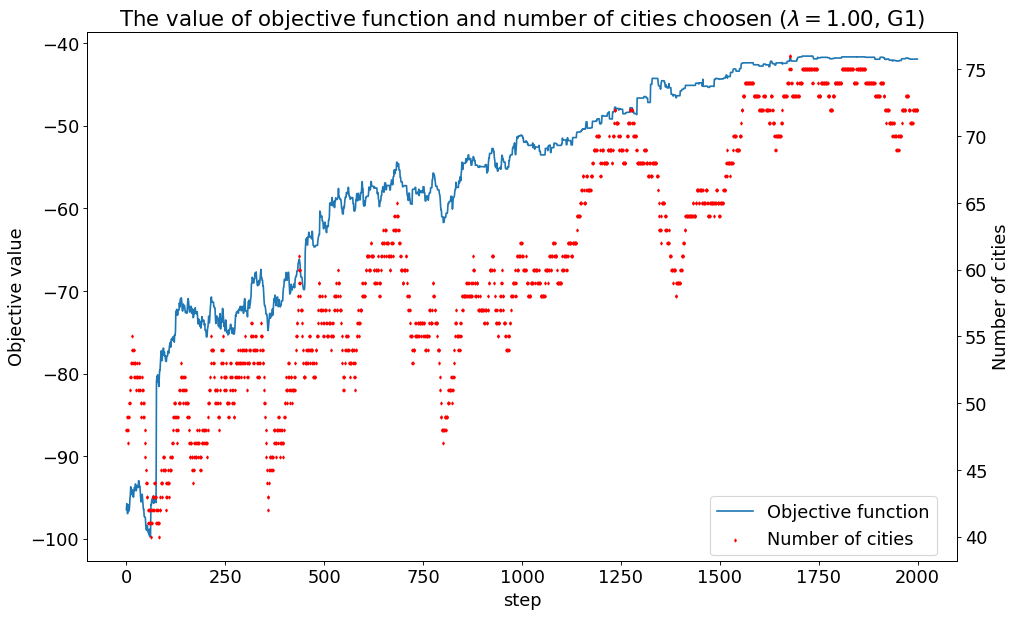

In [15]:
# plt.clf()
# fig, ax1 = plt.subplots()
# fig.set_size_inches(13, 8)
# ax1.plot(range(num_iters), val, label='Objective function')
# ax1.set_xlabel('step')
# ax1.set_ylabel('Objective value')
# ax1.set_title(r'The value of objective function and number of cities choosen ($\lambda={0:.2f}$, {1:s})'.format(lam, gname))

# ax2 = ax1.twinx()
# ax2.scatter(range(num_iters), num_cities, s=3, marker='d', color='r', label='Number of cities')
# ax2.set_ylabel('Number of cities')
# fig.legend(loc='lower right', bbox_to_anchor=(0.92, 0.1))
# fig.tight_layout()

---